In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
brocktonDataPath = './BrocktonPoliceRecords.txt'

In [ ]:
df = pd.read_csv(brocktonDataPath,encoding="latin1", delimiter='|', parse_dates=['Date'])

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = df.replace(np.nan, '', regex=True)

In [5]:
def formatRawData(string):
    def parseData(e):
        parts = e.split('[')
        data = {}
        person = parts[0].split(';')
        data['Number'] = person[0]
        data['Name'] = person[1]
        data['Address'] = person[2]
        data['Age'] = person[3]
        data['Charges'] = parts[1].strip(']').split(';')
        return data
        
    if '//' in string:
        mult = string.split('//')
        parsedData = []
        for element in mult:
            parsedData.append(parseData(element))
        return parsedData
    else:
        return [parseData(string)]

In [6]:
def extractLocation(location):
    
    # Example: [BRO 5855] 206 RIVERVIEW ST -> 206 RIVERVIEW ST
    if location.find('] ') > -1:
        location = location[location.find('] ')+2:]
    
    finalLocation = []
    
    # Example: 634 PLEASANT ST @ 0 WEST ST
    def formatAddressNumber(x):
        # remove leading and trailing whitespace
        x = x.strip()
        # split on spaces and take the first position (the number)
        num = x.split()[0]
        
        if num.isdigit():
            # if the number is 0 it means there is no address and the street should be referd to without a number
            if len(num) == 1 and int(num) == 0:
                #add only the info after the 0; 0 Westgate Ave -> Westgate Ave
                finalLocation.append(' '.join(x.split()[1:]))
            else:
                # add the string to the begining of the list
                finalLocation.insert(0,x)
        else:
            finalLocation.append(x)
    
    if location.find('@') > -1:
        locations = location.split('@')
        for l in locations:
            formatAddressNumber(l)
    else:
        formatAddressNumber(location)
        
    return finalLocation[0]

In [7]:
def formatOfficers(officers):
    
    def parseOfficers(officer):
        parts = officer.split('(')
        times = parts[1].strip(')').split(',')
        return {'Name':parts[0],'Disp':times[0],'Enrt':times[1],'Arvl':times[2],'Clrd':times[3]}
    
    if '//' in officers:
        mult = officers.split('//')
        parsedData = []
        for o in mult:
            parsedData.append(parseOfficers(o))
        return parsedData
    else:
        return [parseOfficers(officers)]

In [8]:
def getRawDataCharges(string):
    data = formatRawData(string)
    ac = []
    for d in data:
        if type(d) is dict:
            for charge in d['Charges']:
                ac.append(charge)
    return ac

In [9]:
def minTimeToDispatch(row):
    callTime = row['Call_Time']
    rawOfficers = row['Officers']
    
    officers = formatOfficers(rawOfficers)
    callTime = str(callTime).zfill(4)
    
    ct = timedelta(hours=int(callTime[0:2]), minutes=int(callTime[2:]), seconds=0)
    times = []
    for officer in officers:
        if len(officer['Disp']) > 0:
            disp = officer['Disp'].split(':')
            ot = timedelta(hours=int(disp[0]), minutes=int(disp[1]), seconds=int(disp[2]))
            # print(ot,ct,(ot - ct).seconds)
            times.append((ot - ct).seconds)
    
    if len(times) > 0:
        # use only unique listings, assume same times are in the same cruser and should be counted as one time
        times = sorted(times)
        t = 0
        for time in times:
            if time > 1:
                t = time
                break
        if t > 0:
            return t

    

In [10]:
def formatSeconds(sec):
    if not np.isnan(sec):
        if sec:
            sec = int(round(sec))
            hours, remainder = divmod(sec, 3600)
            minutes, seconds = divmod(remainder, 60)
            return str(hours).zfill(2)+':'+ str(minutes).zfill(2)+':'+str(seconds).zfill(2)

In [11]:
def getTimeRange(df,CallReason):

    sub = df.loc[df.Call_Reason == CallReason]

    minV = 10000000
    maxV = 0

    for i in sub.iterrows():
        if i[1]['Min_Time_To_Dispatch'] < minV:
            minV = i[1]['Min_Time_To_Dispatch']
        if i[1]['Min_Time_To_Dispatch'] > maxV:
            maxV = i[1]['Min_Time_To_Dispatch']
            
    print(formatSeconds(minV),formatSeconds(maxV))


In [12]:
def subcategorybar(X, vals, width=0.8, digitOffest1=.05,digitOffest2=.03,digitOffest3=.01,delim=''):
    n = len(vals)
    _X = np.arange(len(X))
    
    for i in range(n):
        center = _X - width/2. + i/float(n)*width
        w = width/float(n)
        plt.bar(center, vals[i], width=w, align="edge")
        for index,v in enumerate(vals[i]):
            if len(str(v)) == 1:
                plt.text(center[index] + digitOffest1, v + 2, str(v)+delim)
            elif len(str(v)) == 2:
                plt.text(center[index] + digitOffest2, v + 2, str(v)+delim)
            else:
                plt.text(center[index] + digitOffest3, v + 2, str(v)+delim)
        
    plt.xticks(_X, X)

In [13]:
def getCallReasonTotal(callReason,totals):
    for index, c in enumerate(totals.iteritems()):
        if c[0] == callReason:
            return c[1]
    return 0

# Data Cleaning

In [14]:
# for all actions that begin with z, return everything except the z
df['Action'] = df.Action.apply(lambda x: x[2:].title() if x[0] == 'z' or x[0] == 'Z' else x.title())

df.loc[(df['Action'] == 'Arrest(S) Made'),'Action'] = 'Arrest(s) Made'

df.Action.unique()

array(['Cancelled', 'Matter Settled', 'Taken/Referred', 'False Alarm',
       'Arrest(s) Made', 'Report Taken', 'Unfounded', 'False 911 Call',
       'Citation/Warning Issued', 'Under Investigation',
       'No Citation Issued', 'Transported To Hospital',
       'Could Not Locate', 'No Report Taken', 'Complaint Filed',
       'Clear No Action Needed', 'Vehicle Towed', 'Duplicate Call',
       'Hot Sheet', 'Services Rendered', 'Clear Prior To Arrival',
       'Investigated', 'Unknown Action', 'Unable To Serve',
       'Extinguished', 'Refer To Other Agency', 'Mitigate Hazard',
       'Order Served In Hand', 'Merge:', 'Fire Non Incident',
       'Field Interrogation', 'Commercial', 'Crisis Intervention',
       'Provide Ems', 'Restore', 'Transp', 'Fire / Code Enforcemen',
       'Accepted', 'No Action', 'Denied Warrant', 'Denied Cori',
       'Ems Non Incident', 'Stairway To Recovery Closed',
       'Unable To Respond'], dtype=object)

In [15]:
df.Call_Reason = df.Call_Reason.str.title()

df.loc[df.Call_Reason == '+Tow Repo/Trespass', 'Call_Reason'] = 'Tow Repo/Trespass'
df.loc[df.Call_Reason == '157Disturbance Loud Music', 'Call_Reason'] = 'Disturbance Loud Music'
df.loc[df.Call_Reason == '911 Transfer To Ambulance Stairway To Recovery Clo', 'Call_Reason'] = '911 Transfer To Ambulance'
df.loc[df.Call_Reason == '911 Transfer To Ambulance Stairway To Recovery Clo', 'Action'] = 'Stairway to Recovery Closed'
df.loc[df.Call_Reason == 'Cdbg Proactive Patrolq', 'Call_Reason'] = 'Cdbg Proactive Patrol'
df.loc[df.Call_Reason == 'Check Motorist Supicious', 'Call_Reason'] = 'Check Motorist Suspicious'
df.loc[df.Call_Reason == 'Check Property9', 'Call_Reason'] = 'Check Property'
df.loc[df.Call_Reason == 'Check Property`', 'Call_Reason'] = 'Check Property'
df.loc[df.Call_Reason == 'Community Police Call1380', 'Call_Reason'] = 'Community Police Call'
df.loc[df.Call_Reason == 'Community Police Callq', 'Call_Reason'] = 'Community Police Call'
df.loc[df.Call_Reason == 'Community Police Call`', 'Call_Reason'] = 'Community Police Call'

#https://www.flpd.org/home/showpublisheddocument?id=4091
df.loc[df.Call_Reason == 'Disturbance//22\'S', 'Call_Reason'] = 'Disturbance - School, Daycare, Child Facility (Weapon)'
df.loc[df.Call_Reason == 'Disturbance/22\'S', 'Call_Reason'] = 'Disturbance - School, Daycare, Child Facility (Weapon)'

df.loc[df.Call_Reason == 'Fire Invest', 'Call_Reason'] = 'Fire Investigation'
df.loc[df.Call_Reason == 'Fire, Investigation', 'Call_Reason'] = 'Fire Investigation'
df.loc[df.Call_Reason == 'Gunshot Call By Shot95Spotter', 'Call_Reason'] = 'Gunshot Call By Shotspotter'
df.loc[df.Call_Reason == 'Call By Shotspotter', 'Call_Reason'] = 'Gunshot Call By Shotspotter'
df.loc[df.Call_Reason == 'Gunshot Shotspotter', 'Call_Reason'] = 'Gunshot Call By Shotspotter'
df.loc[df.Call_Reason == 'Larceny/Forgery/Fraud', 'Call_Reason'] = 'Larceny /Forgery/ Fraud'
df.loc[df.Call_Reason == 'M Va', 'Call_Reason'] = 'M V A'
df.loc[df.Call_Reason == 'Motor Vehicle Stop386', 'Call_Reason'] = 'Motor Vehicle Stop'
df.loc[df.Call_Reason == 'Motor Vehicle Stop`', 'Call_Reason'] = 'Motor Vehicle Stop'
df.loc[df.Call_Reason == 'Motor Vehicle Stop`1', 'Call_Reason'] = 'Motor Vehicle Stop'
df.loc[df.Call_Reason == 'Parking Violation Winter Ban1', 'Call_Reason'] = 'Parking Violation Winter Ban'
df.loc[df.Call_Reason == 'Parking Violation Winter Banq', 'Call_Reason'] = 'Parking Violation Winter Ban'
df.loc[df.Call_Reason == 'Qmotor Vehicle Stop', 'Call_Reason'] = 'Motor Vehicle Stop'
df.loc[df.Call_Reason == 'Rtlarceny Investigation', 'Call_Reason'] = 'Larceny Investigation'
df.loc[df.Call_Reason == 'See The Complai', 'Call_Reason'] = 'See The Complainant'
df.loc[df.Call_Reason == 'See The Complainant53', 'Call_Reason'] = 'See The Complainant'
df.loc[df.Call_Reason == 'Serve 11 Summons', 'Call_Reason'] = 'Serve Summons'
df.loc[df.Call_Reason == 'Tow Repo/Tre178Spass', 'Call_Reason'] = 'Tow Repo/Trespass'
df.loc[df.Call_Reason == 'Towr', 'Call_Reason'] = 'Tow Repo/Trespass'
df.loc[df.Call_Reason == '`Tow Repo/Trespass', 'Call_Reason'] = 'Tow Repo/Trespass'
df.loc[df.Call_Reason == 'Traffic Control\'', 'Call_Reason'] = 'Traffic Control'
df.loc[df.Call_Reason == 'Traffic Control`', 'Call_Reason'] = 'Traffic Control'
df.loc[df.Call_Reason == 'Traffic Controln', 'Call_Reason'] = 'Traffic Control'
df.loc[df.Call_Reason == 'Traffic Controltorr', 'Call_Reason'] = 'Traffic Control'
df.loc[df.Call_Reason == 'Violation Of A 209A Order', 'Call_Reason'] = 'Restraining Order Violation'
df.loc[df.Call_Reason == '209S', 'Call_Reason'] = 'Restraining Order Violation'
df.loc[df.Call_Reason == '`911 Transfer To Ambulance', 'Call_Reason'] = '911 Transfer To Ambulance'
df.loc[df.Call_Reason == '`Motor Vehicle Stop', 'Call_Reason'] = 'Motor Vehicle Stop'
df.loc[df.Call_Reason == 'See The 33 Threats', 'Call_Reason'] = 'Threats See The Complainant'
df.loc[df.Call_Reason == 'Brockton High School Graduatio', 'Call_Reason'] = 'Brockton High School Graduation'


unq = df.Call_Reason.unique()
print(sorted(unq))

['911 False Call', '911 Hang Up', '911 Transfer Out Of Town', '911 Transfer To Ambulance', '911 Transfer To Fire', '911 Unknown Emergency', '911 Verify Call', 'A & B Dangerous Weapon Gun', 'A & B Dangerous Weapon Invest', 'A & B Dangerous Weapon Knife', 'Abuse Of 911 System', 'Accosting', 'Alarm Audible', 'Alarm Telephone', 'Alarm, Burglar', 'Alarm, Hold-Up', 'Alarm, Panic', 'Animal Complaint', 'Animal Complaint Barking(Dist)', 'Animal Control', 'Animal Control Dog Complaint', 'Annoying Phone Calls', 'Arson & Bombing', 'Arson Invest', 'Assist Animal Control', 'Assist Citizen', 'Assist Dcf', 'Assist Fire', 'Assist Fire And Dpw', 'Assist Fire Or Ambulance', 'Assist Foxboro Pd', 'Assist Lobby', 'Assist Other Agency', 'B & E In Progress', 'B & E Investigate', 'B & E Motor Vehicle', 'B & E Mv Investigation', 'B & E, Attempted', 'Blown Transformer/Fire', 'Bomb Scare', 'Brockton High School Graduation', 'Burglary, Armed', 'Burglary, Invest', 'Burglary, Unarmed', 'Carjacking', 'Cdbg Proactive 

In [16]:
df['Location_FMT'] = df.Location.apply(lambda x: extractLocation(x))

# Questions

In [17]:
# 1. Average Minimum response times for each Call_Reason

df['Min_Time_To_Dispatch'] = df.loc[df.Num_Officers>0].apply(minTimeToDispatch, axis=1)

# Average Minimum Response Times Per Call Reason

In [18]:
s = df.groupby(['Call_Reason'],as_index=False)['Min_Time_To_Dispatch'].mean()
s = s.sort_values('Min_Time_To_Dispatch', ascending=False)
print('HH:MM:SS',"       ",'Call Reason')
for e in s.iterrows():
    print(formatSeconds(e[1][1]),"       ",e[1][0])
    

HH:MM:SS         Call Reason
04:07:00         Missing People
03:05:06         Liquor Law Violation
01:09:25         Traffic Control
01:08:16         Vandalism
01:03:45         Malicious Damage Investigation
01:02:54         Serve Summons
01:02:51         Larceny Investigation
01:02:23         Code Enforcement
01:01:36         Larceny Of A Bicycle
01:00:35         Runaway Investigation
00:59:10         B & E Mv Investigation
00:58:12         Shoplifting Investigation
00:57:11         Annoying Phone Calls
00:56:28         Cdbg Proactive Patrol
00:56:11         Threats See The Complainant
00:55:11         Malicious Damage Motor Vehicle
00:54:48         B & E, Attempted
00:53:47         Check Mv Abandoned
00:53:39         Arson Invest
00:53:37         Larceny Of A Motor Veh Plate
00:53:29         Motor Vehicle Abandoned
00:52:29         Parking Violation
00:52:17         Arson & Bombing
00:52:09         Check Abandoned Building
00:51:12         Code License Violation
00:50:47         B & E

In [19]:
# Create Charges Dataframe

c_ids = []
a_ids = []
charges = []
ages = []
dates = []
types = []
call_reasons = []

subset = df.loc[(df['Num_Arrest_Charges'] > 0) | (df['Num_Summons_Charges'] > 0)]

for index, row in subset.iterrows():
    cid = row['Call_Number']
    date = row['Date']
    call_reason = row['Call_Reason']
    if row['Arrests_Raw_Data']:
        data = formatRawData(row['Arrests_Raw_Data'])
        for arrest in data:
            aid = arrest['Number']
            age = arrest['Age']
            for charge in arrest['Charges']:
                dates.append(date)
                c_ids.append(cid)
                a_ids.append(aid)
                types.append('Arrest')
                charges.append(charge)
                call_reasons.append(call_reason)
                ages.append(age)
    if row['Summons_Raw_Data']:
        data = formatRawData(row['Summons_Raw_Data'])
        for summon in data:
            aid = summon['Number']
            age = summon['Age']
            for charge in summon['Charges']:
                dates.append(date)
                c_ids.append(cid)
                a_ids.append(aid)
                types.append('Summon')
                charges.append(charge)
                call_reasons.append(call_reason)
                ages.append(age)
                
charges_df = pd.DataFrame({'Date':dates,'Call_ID':c_ids,'Arrest_ID':a_ids,
                           'Type':types,'Charge':charges,'Call_Reason':call_reasons,
                           'Age':ages})

In [20]:
# Create Arrests Dataframe

c_ids = []
a_ids = []
ages = []
dates = []
types = []
call_reasons = []

subset = df.loc[(df['Num_Arrests'] > 0) | (df['Num_Summons_Charges'] > 0)]

for index, row in subset.iterrows():
    cid = row['Call_Number']
    date = row['Date']
    call_reason = row['Call_Reason']
    if row['Arrests_Raw_Data']:
        data = formatRawData(row['Arrests_Raw_Data'])
        for arrest in data:
            aid = arrest['Number']
            age = arrest['Age']
            try:
                age = int(age)
                if age > 100:
                    #print(age,date,cid)
                    age = 0
            except:
                age = 0
            if age > 0:
                dates.append(date)
                c_ids.append(cid)
                a_ids.append(aid)
                types.append('Arrest')
                call_reasons.append(call_reason)
                ages.append(age)
    if row['Summons_Raw_Data']:
        data = formatRawData(row['Summons_Raw_Data'])
        for summon in data:
            aid = summon['Number']
            age = summon['Age']
            try:
                age = int(age)
                if age > 100:
                    #print(age,date,cid)
                    age = 0
            except:
                age = 0
            if age > 0:
                dates.append(date)
                c_ids.append(cid)
                a_ids.append(aid)
                types.append('Summon')
                call_reasons.append(call_reason)
                ages.append(age)
                
arrests_df = pd.DataFrame({'Date':dates,'Call_ID':c_ids,'Arrest_ID':a_ids,
                           'Type':types,'Call_Reason':call_reasons,
                           'Age':ages})

# Distribution of Ages for Arrests

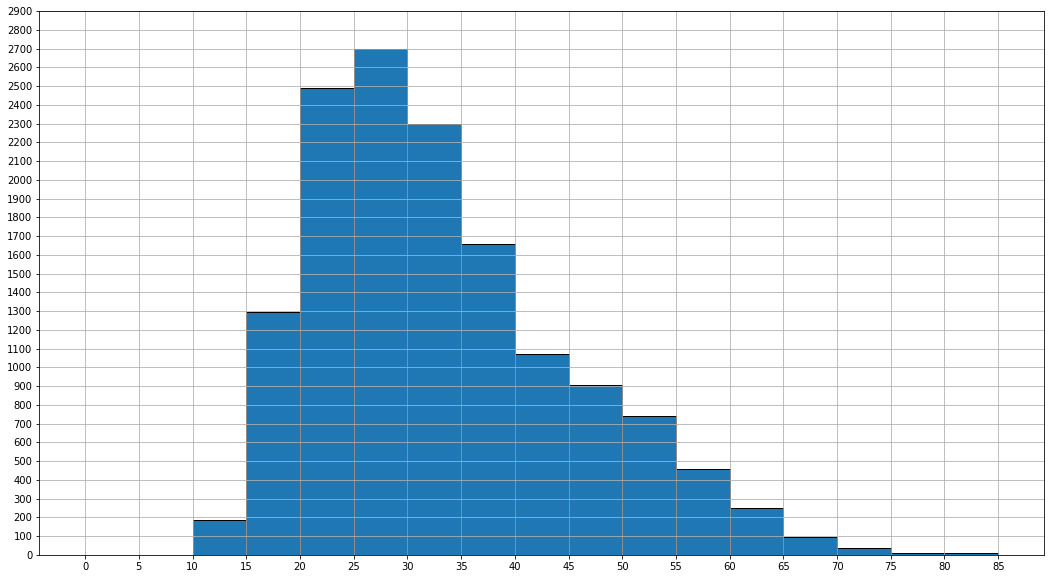

In [21]:
# 2. Graph frequency of arrests by age

plt.figure(figsize=(18,10))

plt.hist(arrests_df['Age'], bins=[x for x in range(0,90,5)],ec='black')
plt.grid()
plt.xticks([x for x in range(0,90,5)])
plt.yticks([x for x in range(0,3000,100)])
plt.show()

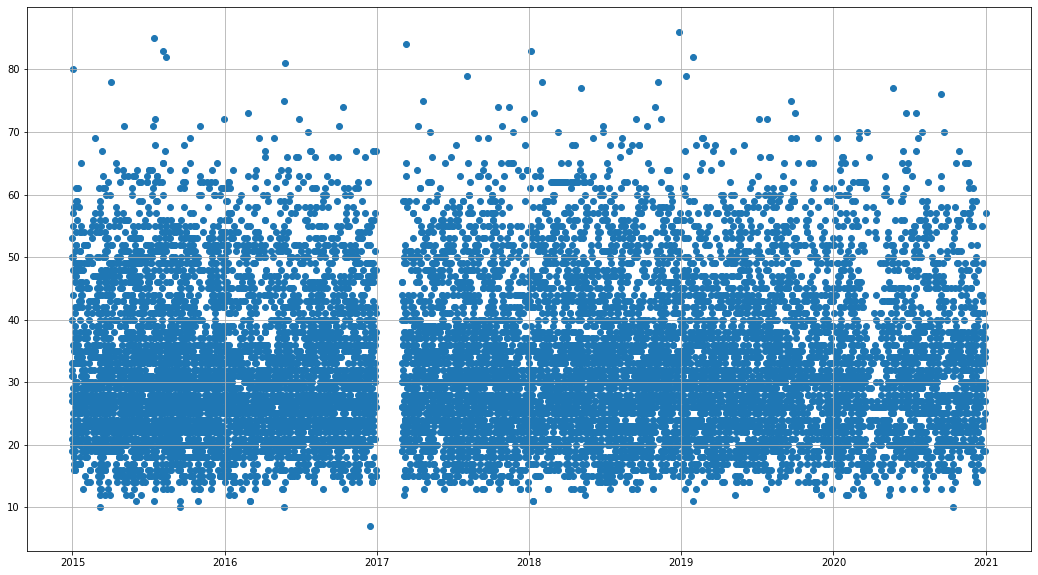

In [22]:
# 2.1 Ages of arrests over time
# 2 months of data is missing from the Brockton Police Website in 2017

plt.figure(figsize=(18,10))

plt.scatter(arrests_df['Date'].tolist(),
            arrests_df['Age'])

plt.grid()
plt.show()

# Correlation Between Charges

In [23]:
# 3. Correlation between the charges

reshaped_charges = pd.crosstab(charges_df.Arrest_ID,charges_df.Charge).reset_index()

reshaped_charges.drop('Arrest_ID',axis=1,inplace=True)

c = reshaped_charges.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

noDupeRelations = []

for e in so.items():
    if e[0][0] != e[0][1]:
        apnd = (e[0][0],e[0][1],e[1]) if e[0][0]>e[0][1] else (e[0][1],e[0][0],e[1])
        noDupeRelations.append(apnd)

noDupeRelations = list(set(noDupeRelations))

print('(Charges1, Charge2, Correlation Strength)',',','Number of Occurrences')
topN = 30
for item in sorted(noDupeRelations, key= lambda x: x[2],reverse=True):

    numInstances = reshaped_charges.loc[(reshaped_charges[item[0]] > 0) &
                         (reshaped_charges[item[1]] > 0)].count()[0]
    
    print(item, numInstances)
    topN -= 1
    if topN == 0:
        break


(Charges1, Charge2, Correlation Strength) , Number of Occurrences
('Motorized Scooters', ' Operating Regulations', 1.0) 9
('FIREARM IN FELONY, POSSESS, SUBSQ.OFF.', 'ABANDON MV', 1.0) 1
('SNOW/REC VEH OPERATING NEGLIGENTLY OR RECKLESSLY', 'SNOW/REC VEH FAILURE TO STOP', 1.0) 4
('INNKEEPER, DEFRAUD, OVER $100', 'CREDIT CARD, RECEIVE IMPROP UNDER $250', 1.0) 1
('Concealing or Harboring Child', ' Aiding /Abetting of Violation of Court Ord', 1.0) 1
('Underage Alcohol Possession', ' Person under 21y will not be charged if seek', 1.0) 2
('UTTER FALSE DOCUMENT', 'FORGERY OF DOCUMENT', 0.7376906433943208) 7
('UTTER FALSE CHECK', 'FORGERY OF CHECK', 0.724010510599616) 48
('KIDNAPPING, FIREARM-ARMED', 'ASSAULT IN DWELLING, FIREARM-ARMED', 0.7070819403519613) 1
('HARASSMENT, CRIMINAL, SUBSQ.OFF.', 'EXTORTION BY THREAT OF INJURY', 0.7070819403519498) 1
('RIOT, INCITE', 'ESCAPE FROM DYS, ATTEMPT', 0.6671791376322912) 7
('Destruction of Property', ' Malicious (-$1,200)', 0.6641644726605328) 19
('UNR

# Number of Arrests / Calls Over Time

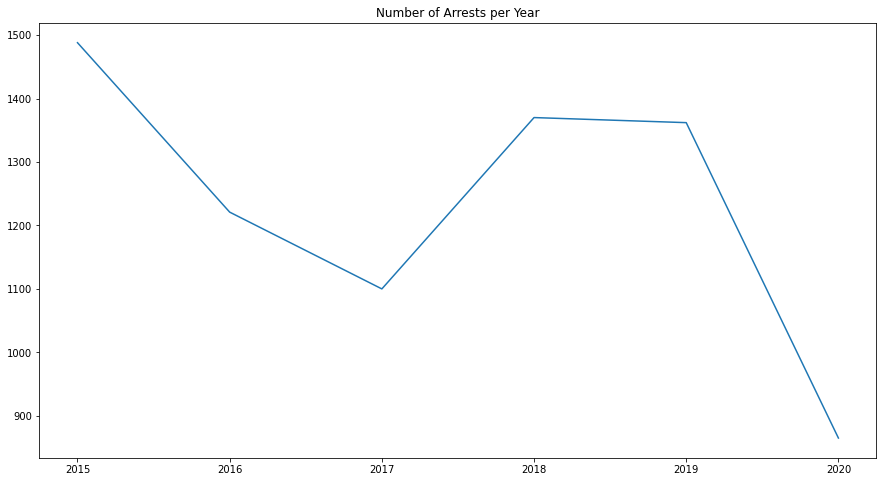

In [24]:
# 4. Number of arrests over time

arrests_by_year = df.Num_Arrests.groupby(df.Date.dt.year).sum()

totals = []
years = []
for y in arrests_by_year.iteritems():
    years.append(y[0])
    totals.append(y[1])
    
plt.figure(figsize=(15,8))
plt.plot(years,totals)
plt.title('Number of Arrests per Year')
plt.show()

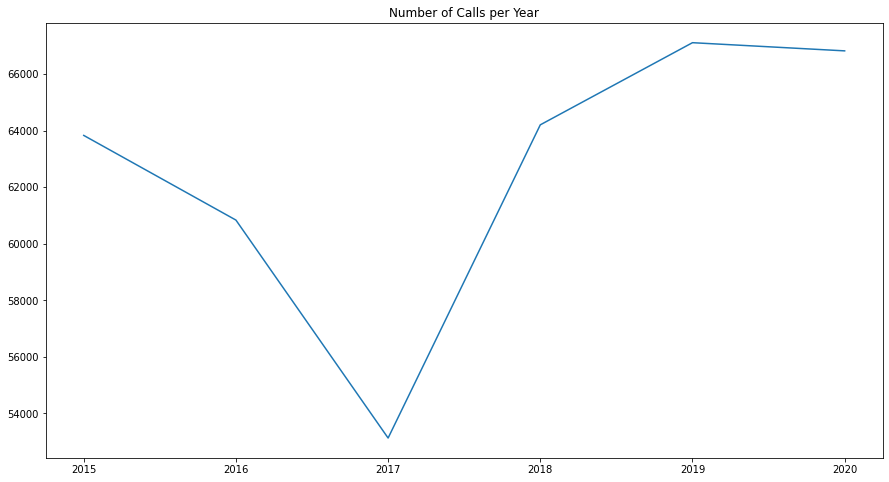

In [25]:
#4.1 Number of total calls per year

num_yearly_calls = df.Date.groupby(df.Date.dt.year).count()

totals = []
years = []
for y in num_yearly_calls.iteritems():
    years.append(y[0])
    totals.append(y[1])

plt.figure(figsize=(15,8))
plt.plot(years,totals)
plt.title('Number of Calls per Year')
plt.show()


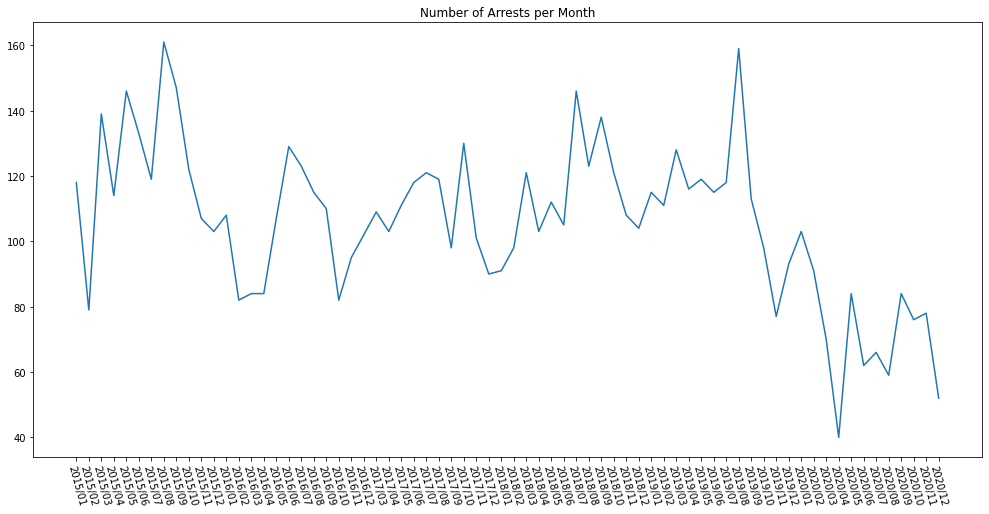

In [26]:
# 4.2 Number of Arrests per month
arrests_by_month = df.Num_Arrests.groupby(df.Date.apply(lambda x: str(x.year)+'/'+str(x.month))).sum()

data = {}
for y in arrests_by_month.iteritems():    
    fmt = y[0].split('/')
    fmt = fmt[0]+'/'+fmt[1].zfill(2)
    
    data[fmt] = y[1]

arrestdata = dict(sorted(data.items()))

plt.figure(figsize=(17,8))
plt.title('Number of Arrests per Month')
plt.plot(arrestdata.keys(),arrestdata.values())
plt.xticks(rotation=-75)
plt.show()


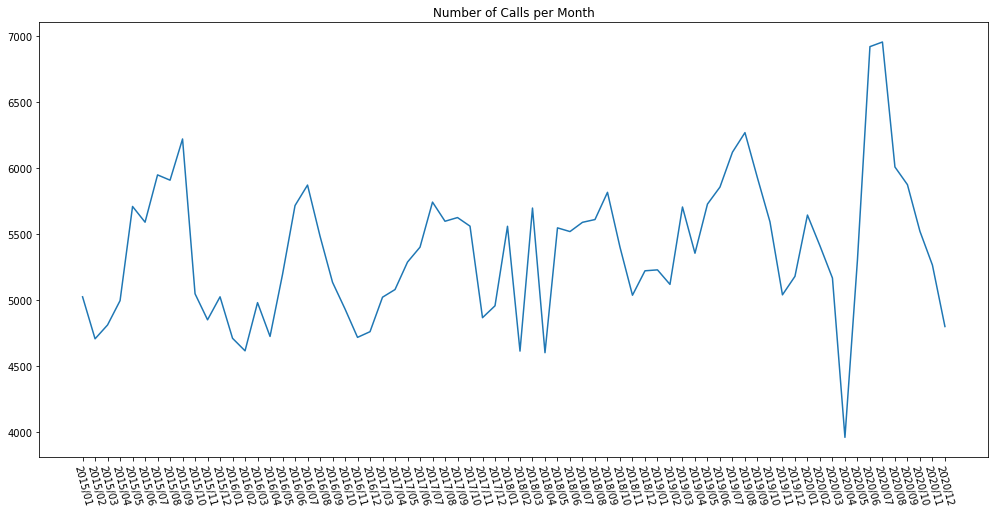

In [27]:
#4.3 Number of total calls per month

num_monthly_calls = df.Date.groupby(df.Date.map(lambda x: str(x.year)+'/'+str(x.month))).count()

data = {}
for y in num_monthly_calls.iteritems():    
    fmt = y[0].split('/')
    fmt = fmt[0]+'/'+fmt[1].zfill(2)
    
    data[fmt] = y[1]

totaldata = dict(sorted(data.items()))

plt.figure(figsize=(17,8))
plt.title('Number of Calls per Month')
plt.plot(totaldata.keys(),totaldata.values())
plt.xticks(rotation=-75)
plt.show()

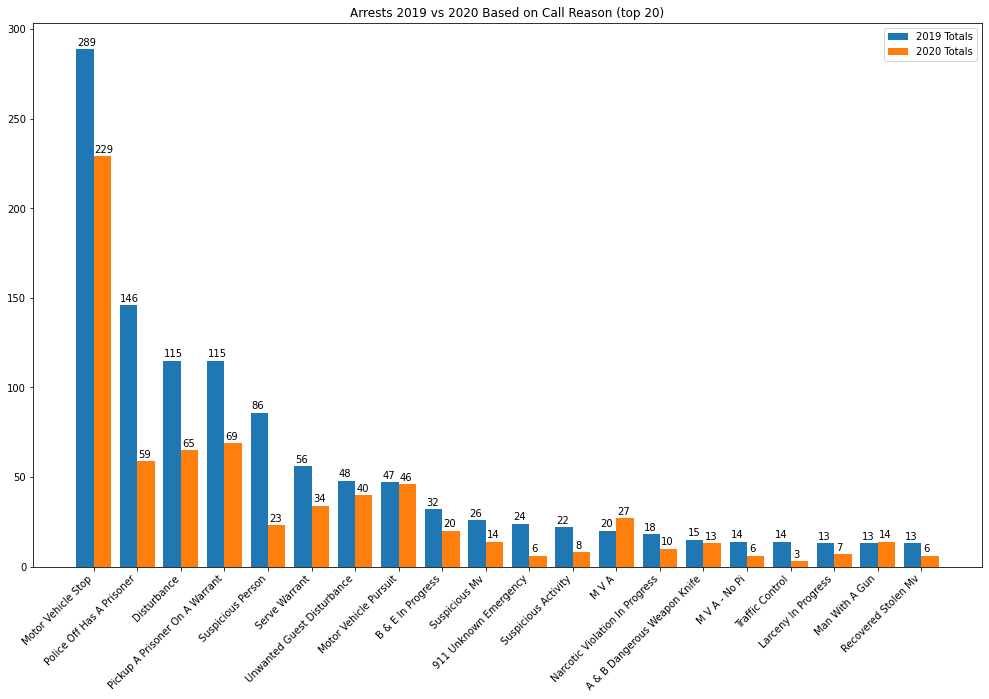

In [28]:
# 4.4 Compare the number of arrests in 2019 vs 2020 to see where the lack of arrests came from

call_reason_totals_2019 = df.Call_Reason.loc[(df.Date.dt.year == 2019)].groupby(df.Call_Reason).count()


call_reasons_for_arrests_2019 = df.Num_Arrests.loc[(df.Num_Arrests > 0) &
                                                        (df.Date.dt.year == 2019)].groupby(df.Call_Reason).sum()

call_reasons_for_arrests_2020 = df.Num_Arrests.loc[(df.Num_Arrests > 0) &
                                                   (df.Date.dt.year == 2020)].groupby(df.Call_Reason).sum()

call_reason_totals_2020 = df.Call_Reason.loc[(df.Date.dt.year == 2020)].groupby(df.Call_Reason).count()


cr = []
num = []
for g in sorted(call_reasons_for_arrests_2019.iteritems(), key=lambda x: x[1], reverse=True):
    cr.append(g[0])
    total = getCallReasonTotal(g[0],call_reason_totals_2019)
    if total != 0:
        v = round((g[1]))
        num.append(v)
    

num1 = []

for i,e in enumerate(cr):
    found = False
    for g in call_reasons_for_arrests_2020.iteritems():
        if e == g[0]:
            v = round(g[1])
            num1.append(v)
            found = True
    if not found:
        num1.append(0)


cutoff = 20
cr = cr[0:cutoff]
num = num[0:cutoff]
num1 = num1[0:cutoff]
plt.figure(figsize=(17,10))
plt.title('Arrests 2019 vs 2020 Based on Call Reason (top '+str(cutoff)+')')
subcategorybar(cr,[num,num1],delim='')
plt.xticks(rotation=45, ha='right')
plt.legend(['2019 Totals','2020 Totals'])
plt.show()


In [29]:
# 4.5 Which Call Reasons have the most resisting arrests charges

resist_arrest_per_call_reason = charges_df.Call_Reason.loc[charges_df.Charge == 'RESIST ARREST'].groupby(charges_df.Call_Reason).count()

for i in sorted(resist_arrest_per_call_reason.iteritems(), key=lambda x: x[1], reverse=True):
    print(i[1],i[0])

124 Disturbance
54 Motor Vehicle Stop
51 Motor Vehicle Pursuit
34 Unwanted Guest Disturbance
27 Police Off Has A Prisoner
20 M V A
16 911 Unknown Emergency
13 Suspicious Person
12 B & E In Progress
10 Disturbance By A Drunk
10 Pickup A Prisoner On A Warrant
8 Narcotic Violation In Progress
8 Suspicious Activity
7 Suspicious Mv
7 Unwanted Guest Drunk
6 Check Property
6 Larceny In Progress
5 Check Motorist Suspicious
5 Robbery
5 Serve Warrant
5 Unwanted Guest Family
4 A & B Dangerous Weapon Invest
4 Gunshot Call By Shotspotter
4 Man With A Gun
4 Party Unconscious
4 Recovered M / V Out Of Town
4 Recovered Stolen Mv
3 911 Hang Up
3 A & B Dangerous Weapon Knife
3 Alarm Telephone
3 B & E Motor Vehicle
3 Hit & Run In Progress
3 M V A - No Pi
3 M V A With Injuries
3 Shoplifting In Progress
3 Threats See The Complainant
2 Assist Fire Or Ambulance
2 Assist Other Agency
2 Check Motorist Drive Erratic
2 Disturbance Loud Music
2 Foot Patrol
2 Larceny Of A M/V Investigation
2 Larceny Of A Motor Vehi

In [30]:
# 4.6 which call types result in the highest number of arrests generated
# and how many officers on average respond to those types of call reasons

call_reason_totals = df.Call_Reason.groupby(df.Call_Reason).count()

avg_officer_per_call_reason = df.Num_Officers.groupby(df.Call_Reason).mean()

call_reasons_arrest_sums = df.Num_Arrests.loc[(df.Num_Arrests > 0)].groupby(df.Call_Reason).sum()

call_reasons_arrest_counts = df.Num_Arrests.loc[(df.Num_Arrests > 0)].groupby(df.Call_Reason).count()

pairs = []

for arrestCount in call_reasons_arrest_counts.iteritems():
    tot = getCallReasonTotal(arrestCount[0],call_reason_totals)
    avgNumOff = getCallReasonTotal(arrestCount[0],avg_officer_per_call_reason)
    totalNumResistArrest = getCallReasonTotal(arrestCount[0],resist_arrest_per_call_reason)
    ratio = 0
    if tot != 0:
        ratio = (arrestCount[1]/tot * 100)
    pairs.append((arrestCount[0],ratio,arrestCount[1],tot,avgNumOff,totalNumResistArrest))
    
pairs = sorted(pairs,key=lambda x: x[2]/x[3], reverse=True)

print('Call Reason,','Ratio','(Arrests / Total Calls),','Avg Num Responding Off,','Total Resist Charges,','Percent of Arrests who Resist')

for pair in pairs:
    print(pair[0],',',str(round(pair[1],2))+'% ','(',str(pair[2]),'/',str(pair[3]),') ,',str(round(pair[4])),',',str(pair[5]),',',str(round(pair[5]/pair[2] *100,2))+'%')

Call Reason, Ratio (Arrests / Total Calls), Avg Num Responding Off, Total Resist Charges, Percent of Arrests who Resist
Arson Invest , 100.0%  ( 1 / 1 ) , 1 , 0 , 0.0%
Foot Pursuit , 100.0%  ( 1 / 1 ) , 5 , 1 , 100.0%
Police Off Has A Prisoner , 81.77%  ( 713 / 872 ) , 2 , 27 , 3.79%
Prisoner Booked , 60.0%  ( 3 / 5 ) , 1 , 0 , 0.0%
Serve Warrant , 51.78%  ( 189 / 365 ) , 3 , 5 , 2.65%
Motor Vehicle Pursuit , 45.9%  ( 179 / 390 ) , 6 , 51 , 28.49%
Pickup A Prisoner On A Warrant , 36.1%  ( 631 / 1748 ) , 2 , 10 , 1.58%
Arson & Bombing , 33.33%  ( 1 / 3 ) , 2 , 0 , 0.0%
Unlawful Poss Dangerous Weapon , 25.0%  ( 1 / 4 ) , 1 , 0 , 0.0%
A & B Dangerous Weapon Knife , 19.84%  ( 73 / 368 ) , 4 , 3 , 4.11%
Carjacking , 18.92%  ( 7 / 37 ) , 4 , 0 , 0.0%
Shoplifting - In Custody , 15.06%  ( 116 / 770 ) , 1 , 2 , 1.72%
Recovered M / V Out Of Town , 11.72%  ( 15 / 128 ) , 2 , 4 , 26.67%
Shoplifting In Progress , 11.68%  ( 66 / 565 ) , 2 , 3 , 4.55%
Investigate Dangerous Weapon , 11.11%  ( 1 / 9 ) 

# Drug Violations by Schedule

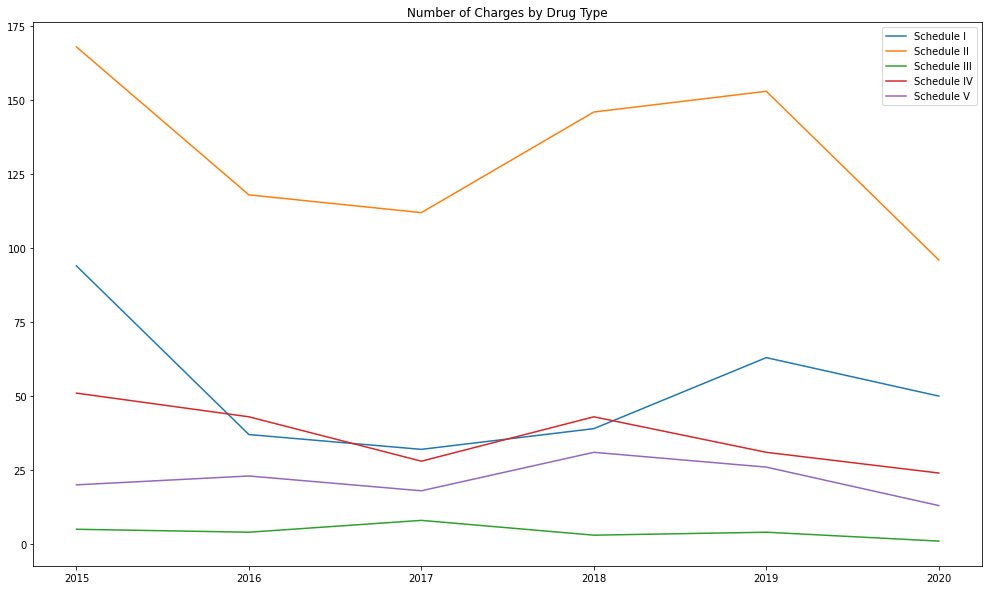

In [31]:
# 5. Types of drug violations over time (A,B,C,D,E), including the break down of possession / distribution charges


y = []
A0= []
B0= []
C0= []
D0= []
E0= []

A1= []
B1= []
C1= []
D1= []
E1= []

A= []
B= []
C= []
D= []
E= []
        
years = charges_df.groupby(charges_df.Date.dt.year)
cyear = ''
for i,year in enumerate(years):
    y.append(year[0])

    
    a0 = b0 = c0 = d0 = e0 = a1 = b1 = c1 = d1 = e1 = a = b = c = d = e = 0
    
    for charge in year[1]['Charge']:
        if type(charge) == str:
            item = charge.title()
            if 'Class A' in item:
                a += 1
                if 'Distrib' in item:
                    a0 += 1
                else:
                    a1 += 1
            elif 'Class B' in item:
                b += 1
                if 'Distrib' in item:
                    b0 += 1
                else:
                    b1 += 1
            elif 'Class C' in item:
                c += 1
                if 'Distrib' in item:
                    c0 += 1
                else:
                    c1 += 1
            elif 'Class D' in item:
                d += 1
                if 'Distrib' in item:
                    d0 += 1
                else:
                    d1 += 1
            elif 'Class E' in item:
                e += 1
                if 'Distrib' in item:
                    e0 += 1
                else:
                    e1 += 1
          

    A0.append(a0)
    B0.append(b0)
    C0.append(c0)
    D0.append(d0)
    E0.append(e0)
    
    A1.append(a1)
    B1.append(b1)
    C1.append(c1)
    D1.append(d1)
    E1.append(e1)
    
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    E.append(e)

drugData = pd.DataFrame(dict(A0=A0,B0=B0,C0=C0,D0=D0,E0=E0,A1=A1,B1=B1,C1=C1,D1=D1,E1=E1))

plt.figure(figsize=(17,10))
plt.title('Number of Charges by Drug Type')

    

plt.plot(y, A, label = "Schedule I")

plt.plot(y, B, label = "Schedule II")

plt.plot(y, C, label = "Schedule III")

plt.plot(y, D, label = "Schedule IV")

plt.plot(y, E, label = "Schedule V")


plt.legend()
plt.show()



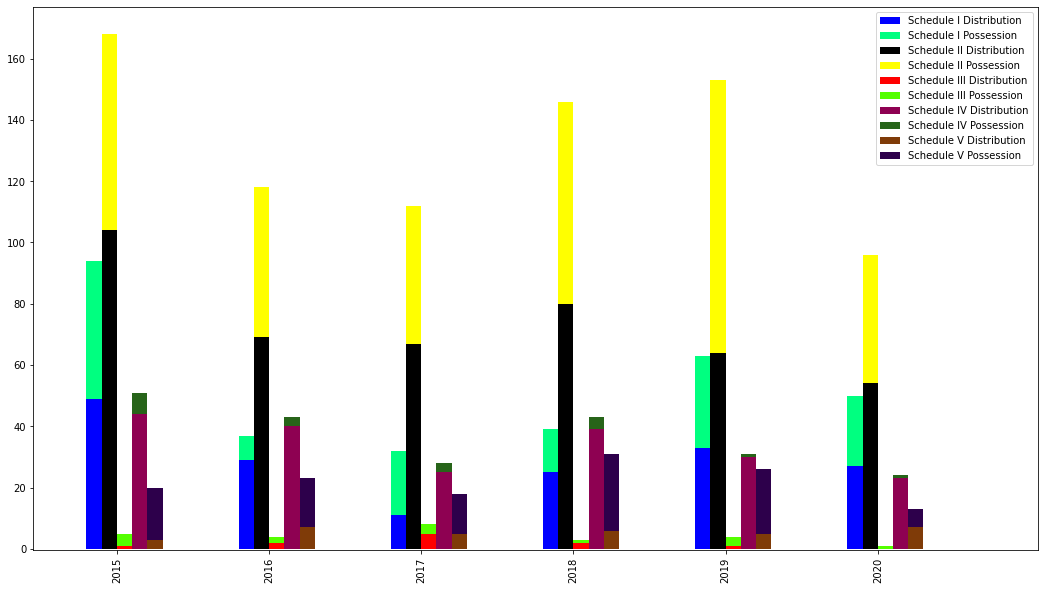

In [32]:
fig, ax = plt.subplots(figsize=(18,10))
drugData[['A0', 'A1']].plot.bar(stacked=True, width=0.1, position=2, colormap="winter", ax=ax)
drugData[['B0', 'B1']].plot.bar(stacked=True, width=0.1, position=1, colormap="gnuplot", ax=ax)
drugData[['C0', 'C1']].plot.bar(stacked=True, width=0.1, position=0, colormap="prism", ax=ax)
drugData[['D0', 'D1']].plot.bar(stacked=True, width=0.1, position=-1, colormap="PiYG", ax=ax)
drugData[['E0', 'E1']].plot.bar(stacked=True, width=0.1, position=-2, colormap="PuOr", ax=ax)

plot_margin = .5

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))

plt.xticks([0,1,2,3,4,5],['2015','2016','2017','2018','2019','2020'])
ax.legend(["Schedule I Distribution","Schedule I Possession","Schedule II Distribution",
           "Schedule II Possession","Schedule III Distribution","Schedule III Possession",
           "Schedule IV Distribution","Schedule IV Possession","Schedule V Distribution","Schedule V Possession"])
plt.show()

